In [12]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn

import seaborn as sns
import matplotlib.pyplot as plt
import math

- #### 설명

- CNN의 동작 원리를 완전히 파해치는 것은 본 프로젝트의 주된 목적과는 거리가 멀다고 판단  
- MNIST 훈련 데이터로 학습한 모델에서 테스트 데이터로 테스트 한 정확도가 98.88%가 나왔다는 것은 입력 데이터가 CNN의 각 레이어를 지나갈 때마다 더 유의미한 특징들로 변환된다는 의미로 해석 가능  
- 레이어를 통과할 때마다 차원 정의  
    - 입력 데이터 차원 : (N, 1, 28 28)
    - conv1 레이어 통과 후 차원 : (N, 64, 29, 29)
    - pool 레이어 통과 후 차원 : (N, 64, 14, 14)
    - conv2 레이어 통과 후 차원 : (N, 32, 15, 15)
    - pool 레이어 후 차원 : (N, 32, 7, 7)
    - flatten 레이어 통과 후 차원 : (N, 1568)
    - fc1 레이어 통과 후 차원 : (N, 256)

- 추출된 256 차원의 고수준 특징으로 차원 축소를 하면 라벨 간 분리가 더 잘되지 않을까?

- #### CNN 모델과 특징 추출용 모델

In [13]:
# 모델 정의
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=2, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.3)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=2, padding=1)
        self.dropout2 = nn.Dropout(0.3)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 7 * 7, 256)
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = self.dropout1(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout2(x)
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout3(x)
        x = self.fc2(x)
        return x

class FeatureExtractor(nn.Module):
    def __init__(self, original_model):
        super(FeatureExtractor, self).__init__()
        # Sequential로 모델의 구조를 분리
        self.conv1 = nn.Sequential(
            original_model.conv1,
            nn.ReLU(),
        )
        self.pool1 = nn.Sequential(
            original_model.pool,
            original_model.dropout1,
        )
        self.conv2 = nn.Sequential(
            original_model.conv2,
            nn.ReLU(),
        )
        self.pool2 = nn.Sequential(
            original_model.pool,
            original_model.dropout2,
        )
        self.flatten = original_model.flatten
        self.fc1 = nn.Sequential(
            original_model.fc1,
            nn.ReLU(),
            original_model.dropout3,
        )
        self.fc2 = original_model.fc2

    def forward(self, x):
        conv1_output = self.conv1(x)                # 첫 번째 컨볼루션 레이어
        pool1_output = self.pool1(conv1_output)     # 첫 번째 풀링 레이어
        conv2_output = self.conv2(pool1_output)     # 두 번째 컨볼루션 레이어
        pool2_output = self.pool2(conv2_output)     # 두 번째 풀링 레이어
        flatten_output = self.flatten(pool2_output) # Flatten
        fc1_output = self.fc1(flatten_output)       # 첫 번째 Fully Connected 레이어
        fc2_output = self.fc2(fc1_output)           # 최종 Fully Connected 레이어 (분류)

        # 각 단계별 출력을 반환
        return {
            "conv1_output": conv1_output,
            "pool1_output": pool1_output,
            "conv2_output": conv2_output,
            "pool2_output": pool2_output,
            "flatten_output": flatten_output,
            "fc1_output": fc1_output,
            "fc2_output": fc2_output,
        }

- #### 이미지 데이터가 어떻게 변해가지는 예시

In [14]:
# MNIST 데이터 로드
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)

In [15]:
data_iter = iter(train_loader)
image, label = next(data_iter)
print(f"Image Shape: {image.shape}, Label: {label.item()}")

Image Shape: torch.Size([1, 1, 28, 28]), Label: 5


In [16]:
model = torch.load('../models/cnn_model.pth')
model.eval()

extractor = FeatureExtractor(model)
outputs = extractor(image)

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_23888\4236334176.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('../models/cnn_model.pth')


In [17]:
print(f"conv1 데이터 차원 : {outputs['conv1_output'].shape}")
print(f"conv1->pool 데이터 차원 : {outputs['pool1_output'].shape}")
print(f"conv2 데이터 차원 : {outputs['conv2_output'].shape}")
print(f"conv2->pool 데이터 차원 : {outputs['pool2_output'].shape}")
print(f"flattem 데이터 차원 : {outputs['flatten_output'].shape}")
print(f"fc1_output 데이터 차원 : {outputs['fc1_output'].shape}")
print(f"fc2_output 데이터 차원 : {outputs['fc2_output'].shape}")

conv1 데이터 차원 : torch.Size([1, 64, 29, 29])
conv1->pool 데이터 차원 : torch.Size([1, 64, 14, 14])
conv2 데이터 차원 : torch.Size([1, 32, 15, 15])
conv2->pool 데이터 차원 : torch.Size([1, 32, 7, 7])
flattem 데이터 차원 : torch.Size([1, 1568])
fc1_output 데이터 차원 : torch.Size([1, 256])
fc2_output 데이터 차원 : torch.Size([1, 10])


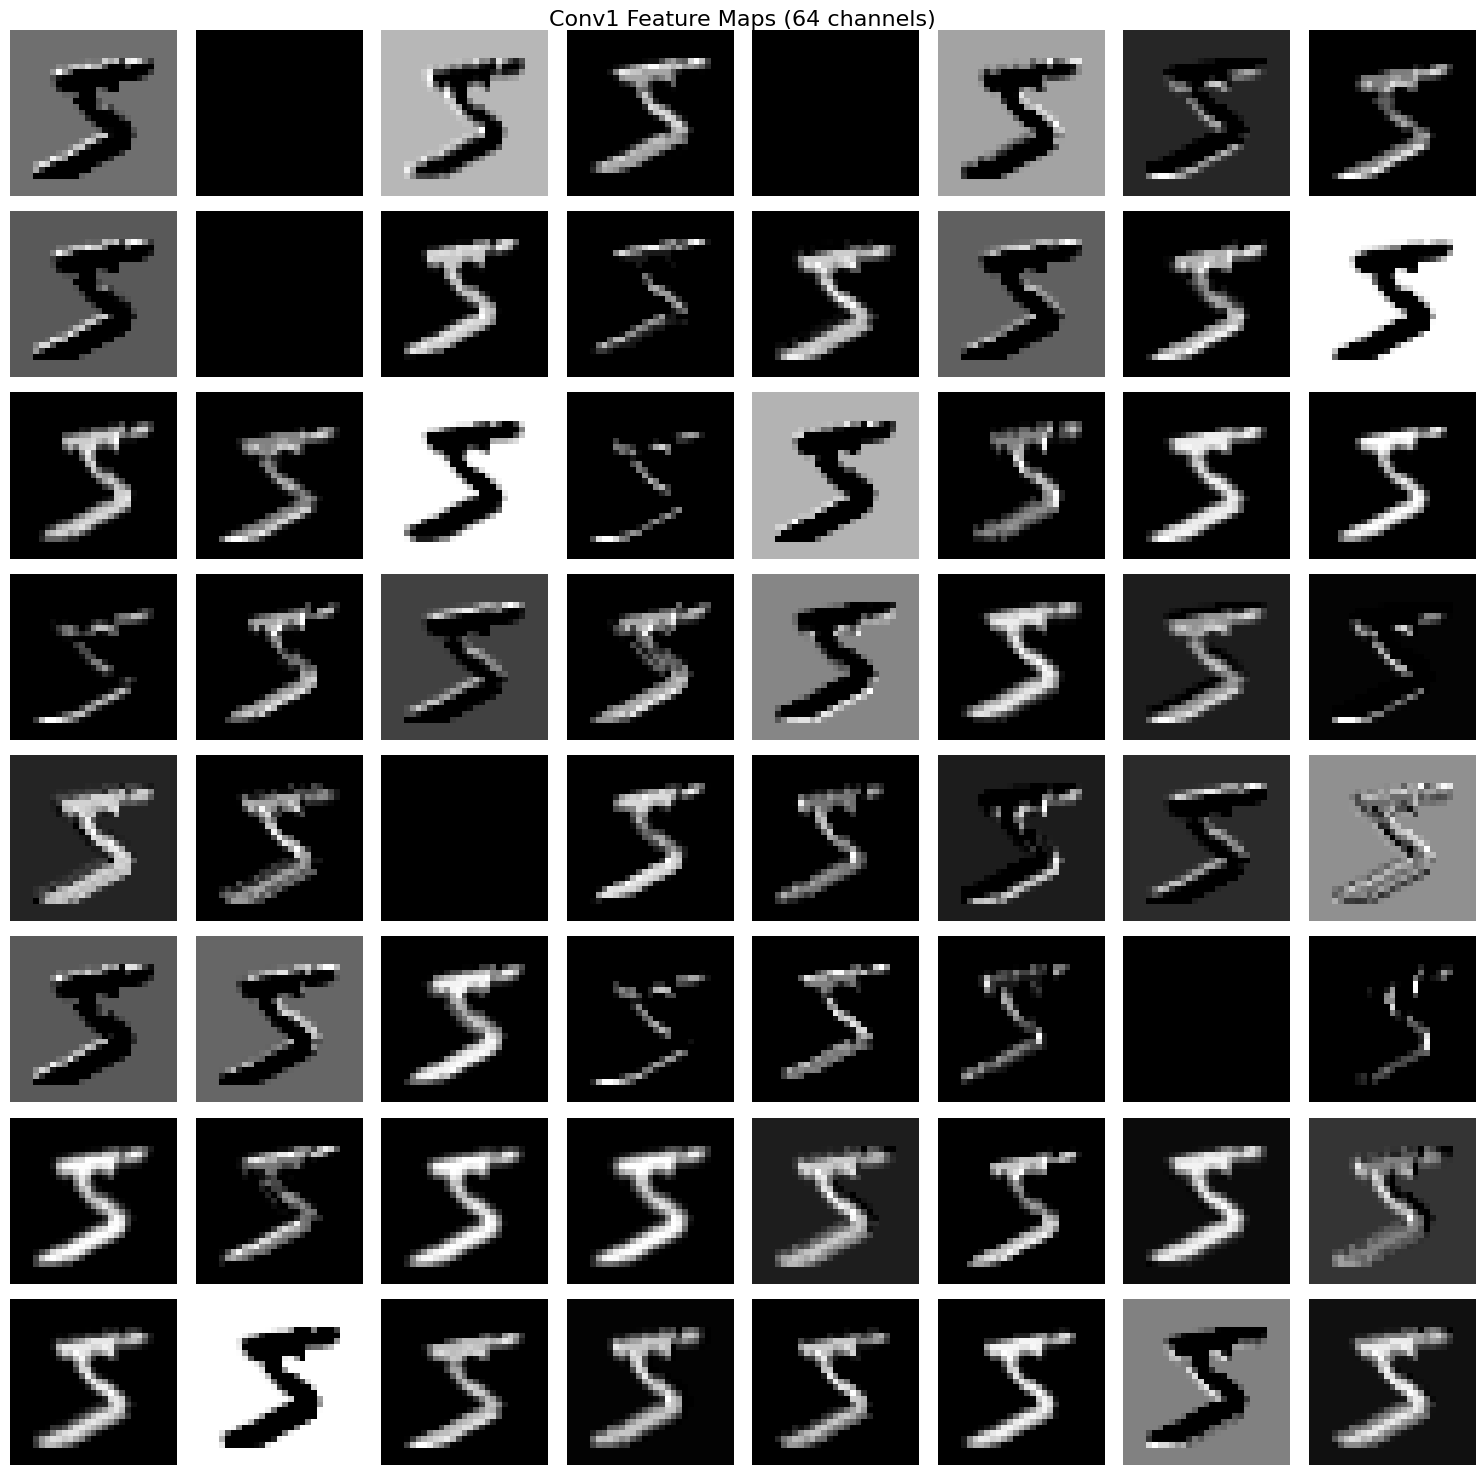

In [18]:
def visualize_feature_maps(feature_maps, layer_name):
    """
    특징 맵 시각화 함수.
    모든 채널의 특징 맵을 시각화합니다.
    """
    feature_maps = feature_maps.squeeze(0)  # 배치 차원 제거
    num_channels = feature_maps.shape[0]  # 채널 수 가져오기
    
    # 서브플롯 행과 열 계산 (정사각형 레이아웃에 가깝게)
    num_cols = math.ceil(math.sqrt(num_channels))  # 열 수
    num_rows = math.ceil(num_channels / num_cols)  # 행 수
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
    fig.suptitle(f"{layer_name} Feature Maps ({num_channels} channels)", fontsize=16)
    
    # 각 채널의 특징 맵 시각화
    for i in range(num_channels):
        row, col = divmod(i, num_cols)  # 행, 열 계산
        ax = axes[row, col] if num_rows > 1 else axes[col]
        ax.imshow(feature_maps[i].detach().cpu().numpy(), cmap="gray")
        ax.axis("off")
    
    # 빈 서브플롯 숨기기
    for j in range(i + 1, num_rows * num_cols):
        row, col = divmod(j, num_cols)
        ax = axes[row, col] if num_rows > 1 else axes[col]
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()


# 시각화 예제
visualize_feature_maps(outputs["conv1_output"], "Conv1")

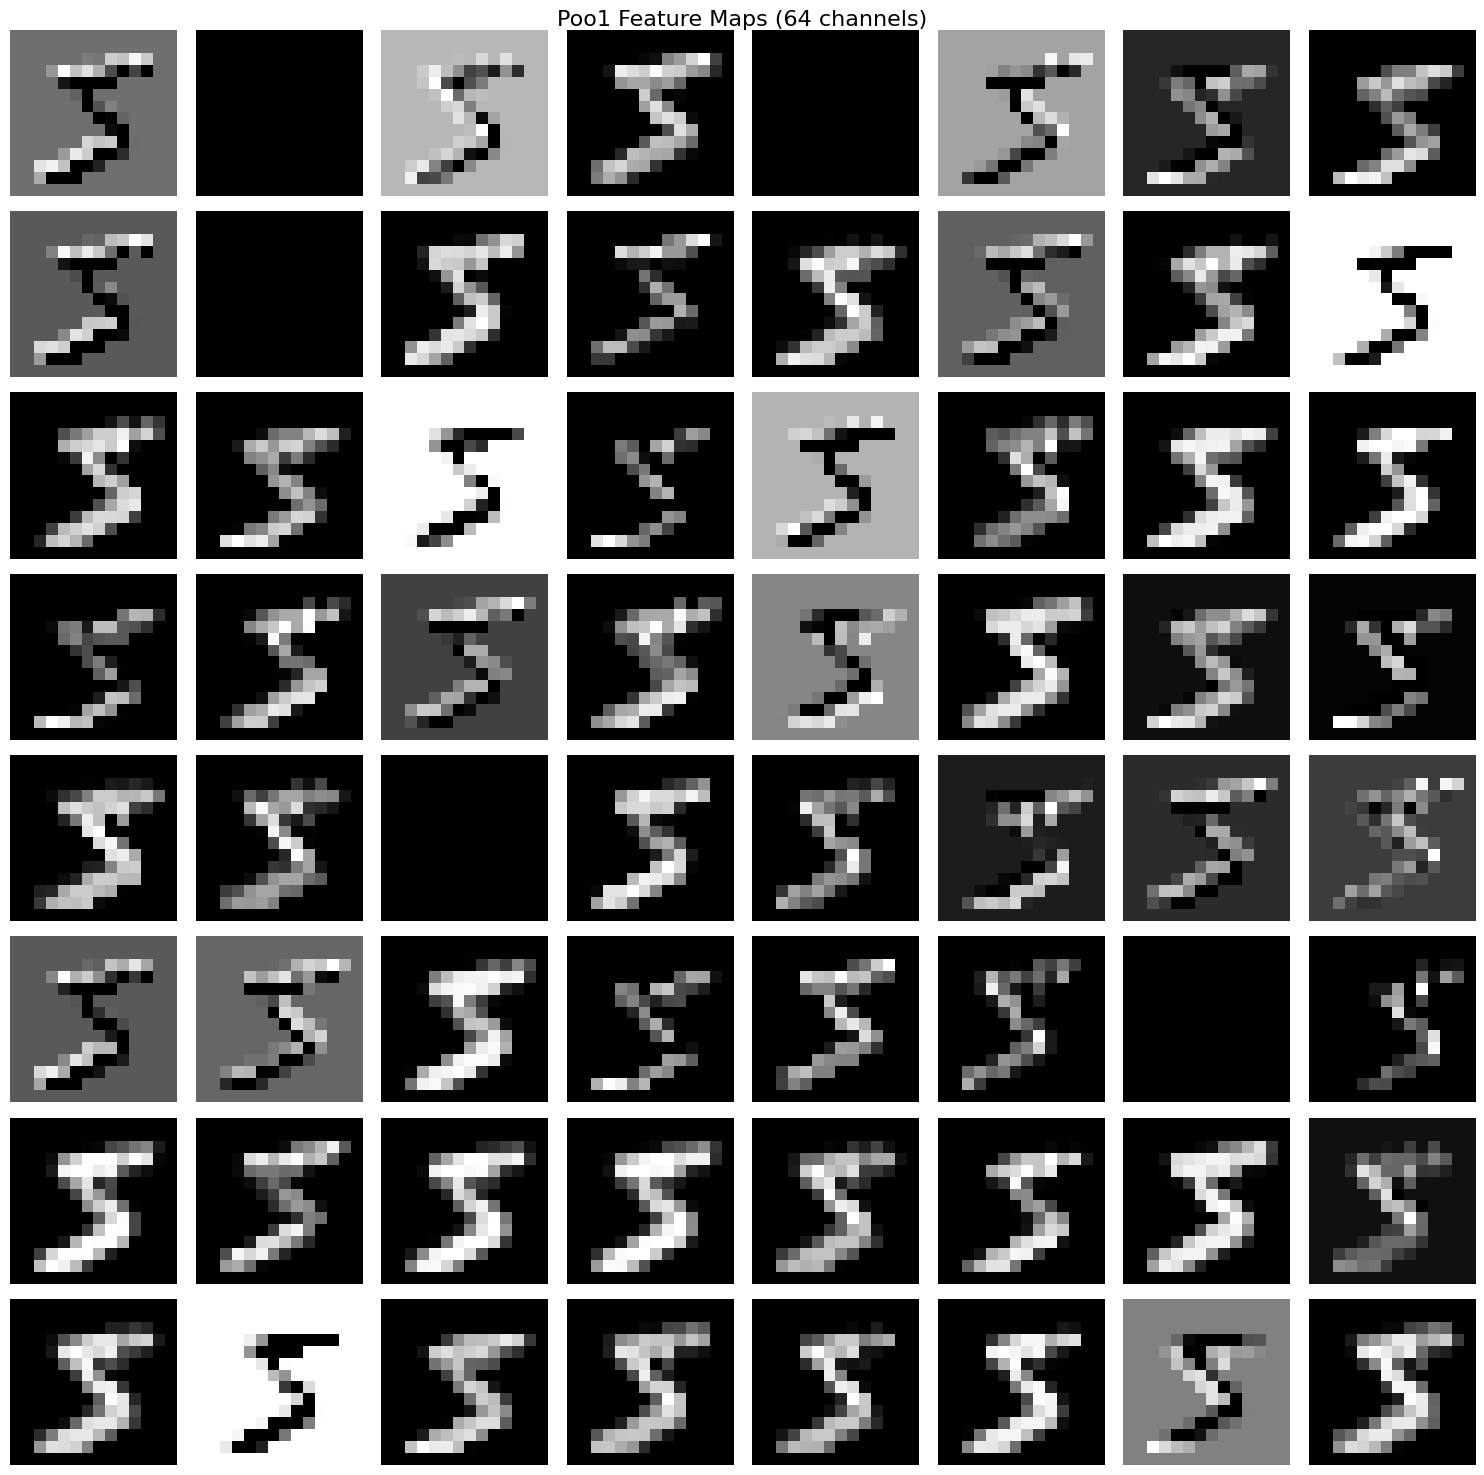

In [19]:
visualize_feature_maps(outputs["pool1_output"], "Poo1")

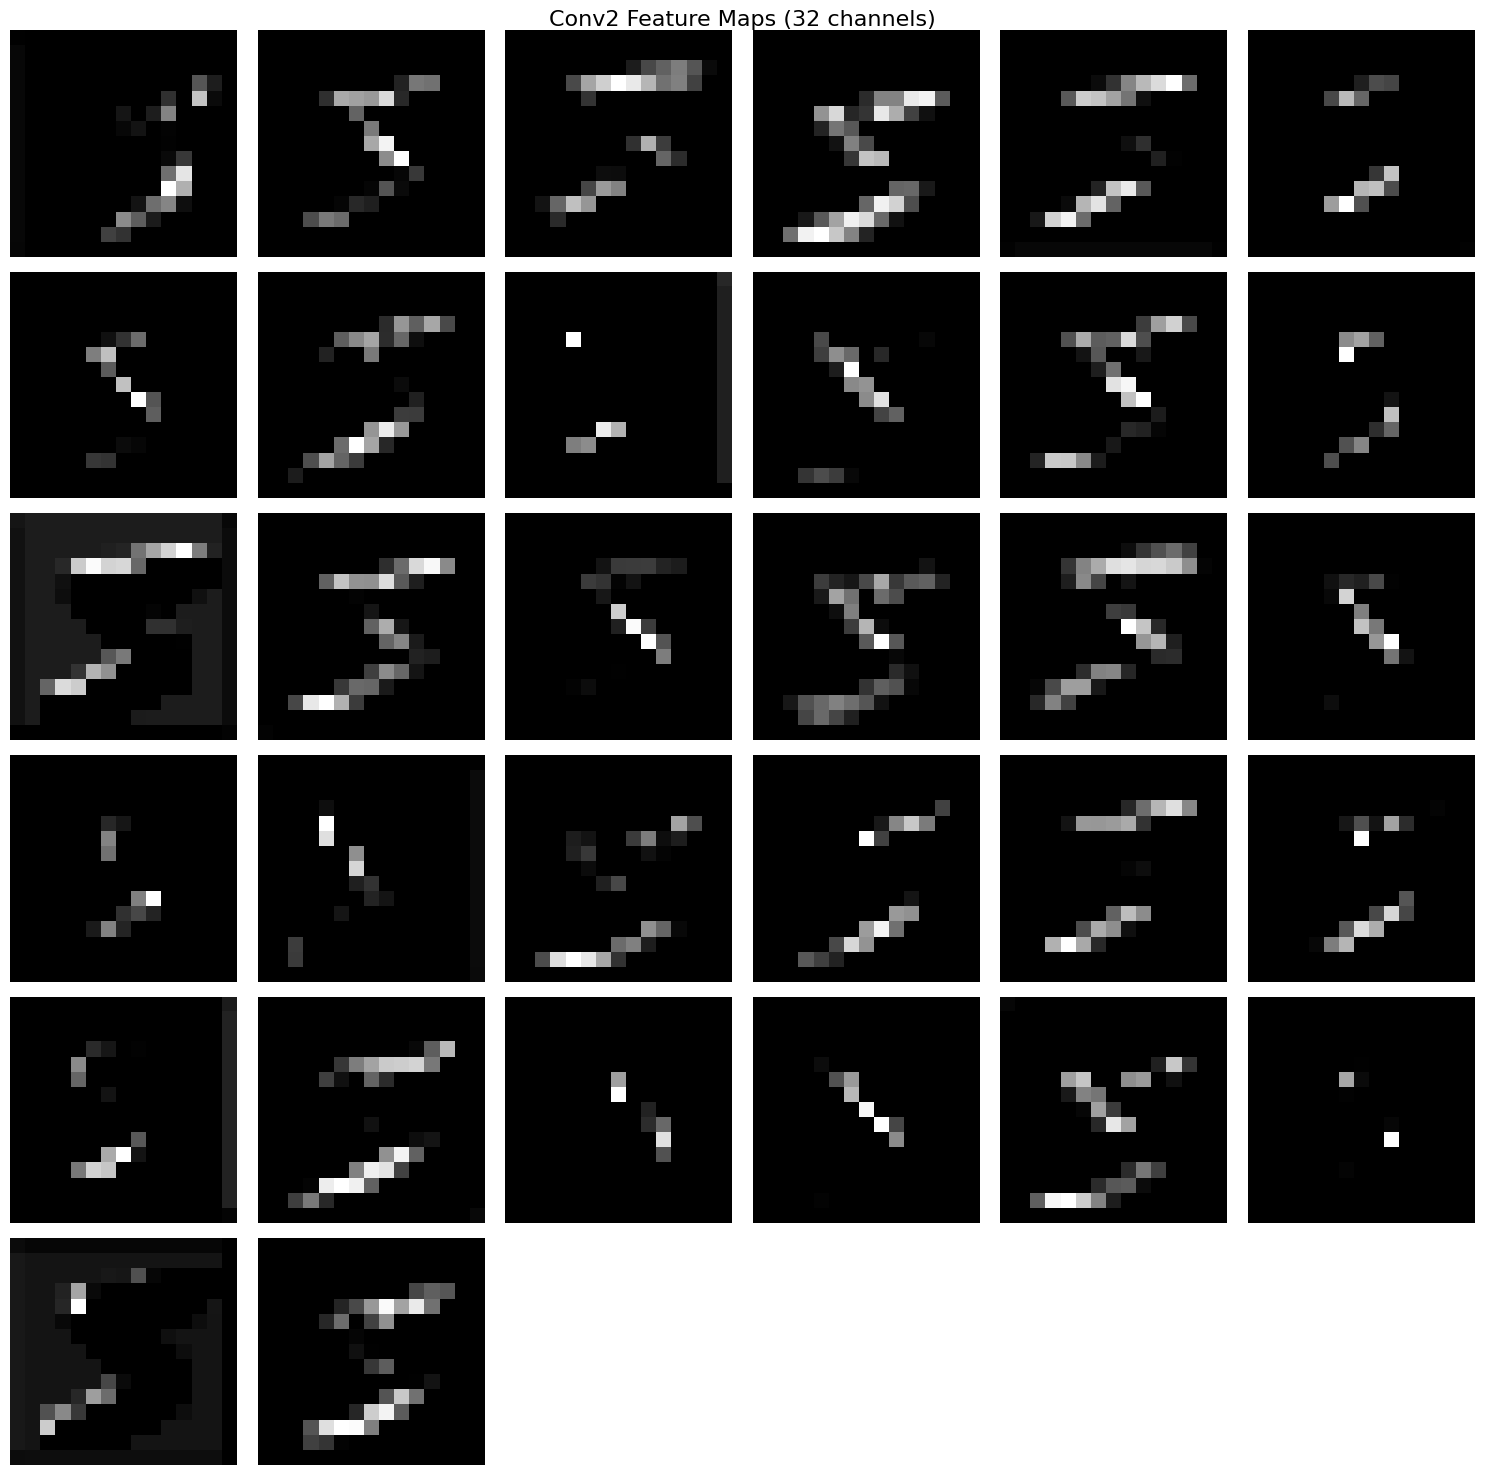

In [20]:
visualize_feature_maps(outputs["conv2_output"], "Conv2")

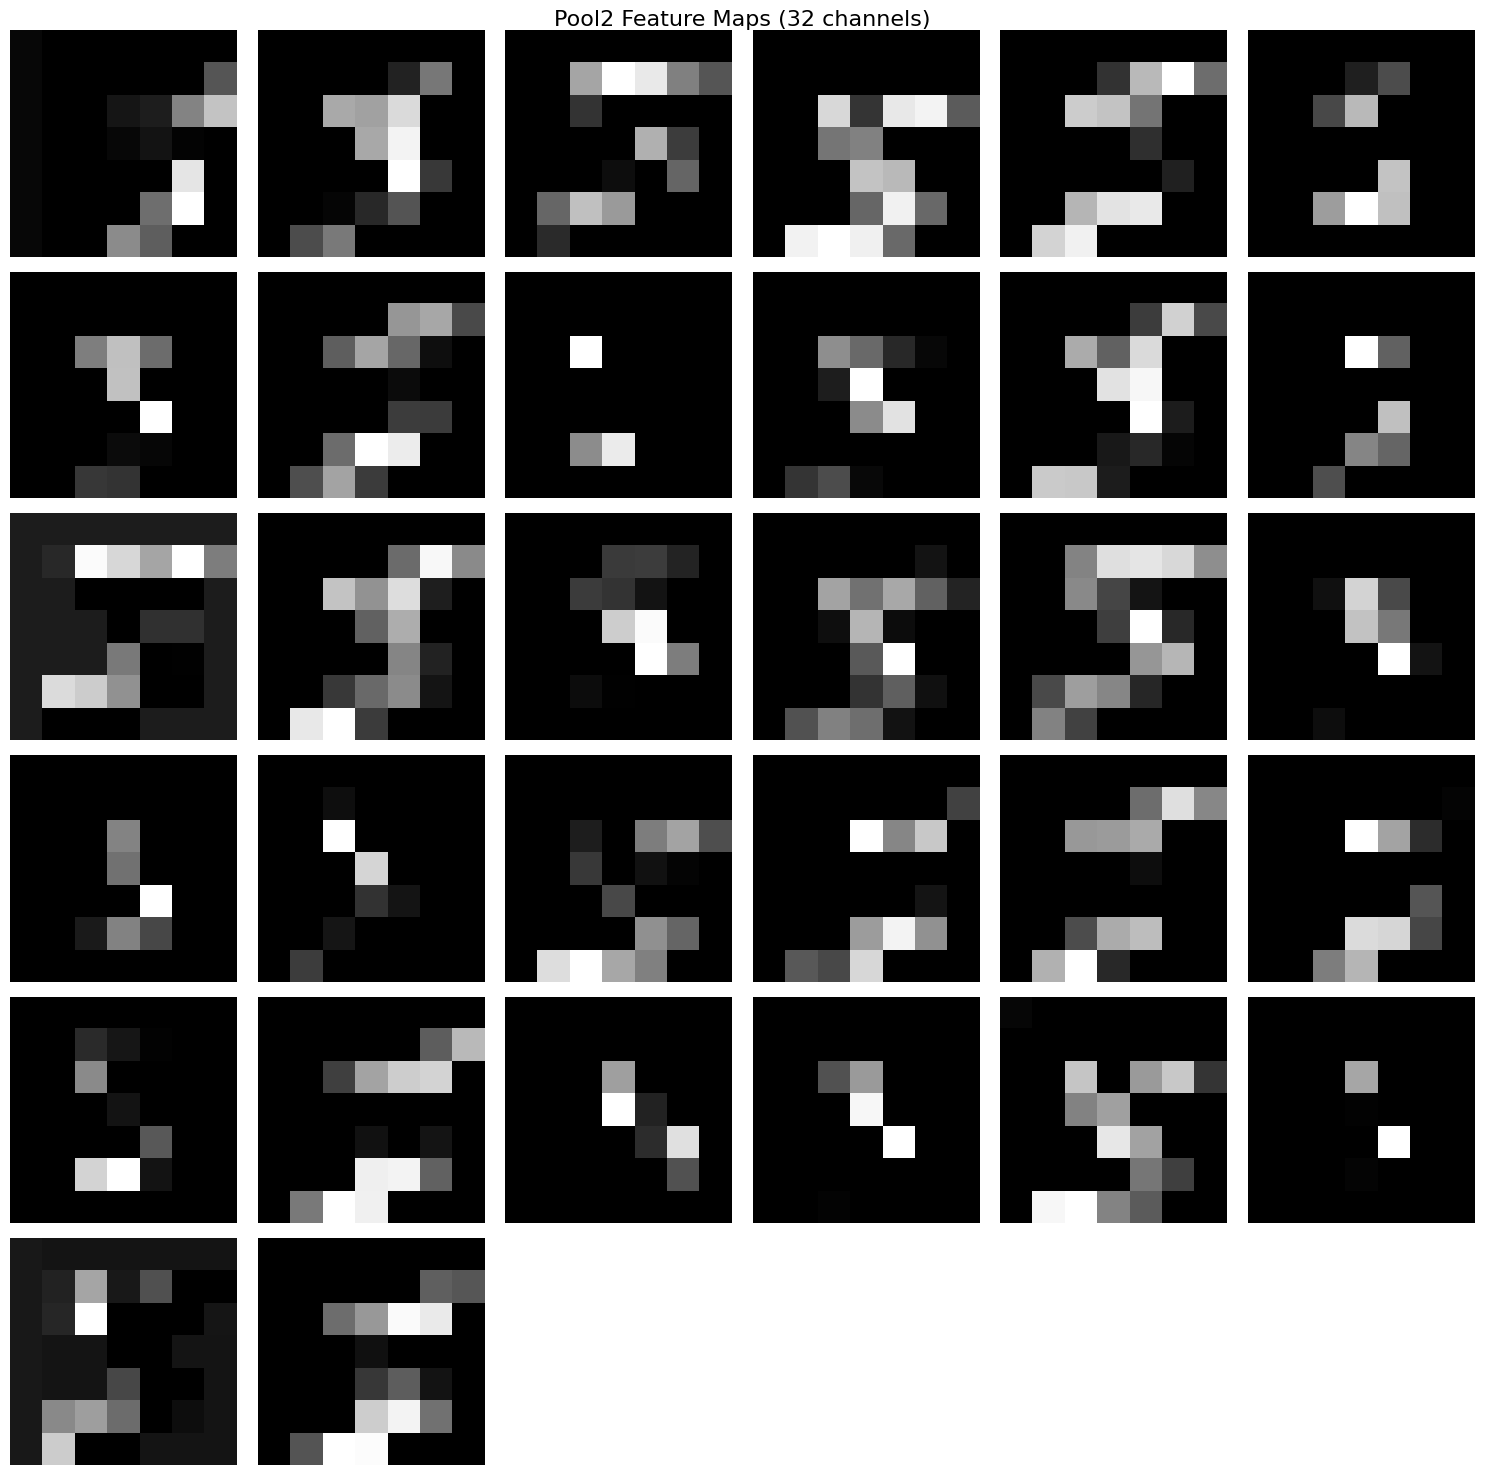

In [21]:
visualize_feature_maps(outputs["pool2_output"], "Pool2")